In [11]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift
from torch.utils.data import DataLoader
import galsim
from dataset import Galaxy_Dataset, get_COSMOS_Galaxy, get_LSST_PSF
from models.Wiener import Wiener
from models.Richard_Lucy import Richard_Lucy
from models.Unrolled_ADMM import Unrolled_ADMM
from utils.utils import PSNR, estimate_shear

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Define basic parameters

In [12]:
COSMOS_dir = '/mnt/WD6TB/tianaoli/COSMOS_23.5_training_sample/'
real_galaxy_catalog = galsim.RealGalaxyCatalog(dir=COSMOS_dir, sample=str(23.5))

fov_pixels = 48
pixel_scale = 0.2
gal_max_shear = 0.5
seeing = 0.7
atmos_max_shear = 0.2

### Simulate PSF

In [13]:
rng = galsim.UniformDeviate(seed=19) # Initialize the random number generator
rng_gaussian = galsim.GaussianDeviate(seed=34, mean=seeing, sigma=0.18)
# PSF parameters
atmos_fwhm = 0.7 # arcsec (mean 0.7 for LSST)
# while atmos_fwhm < 0.35 or atmos_fwhm > 1.1: # sample fwhm
#     atmos_fwhm = rng_gaussian()
# atmos_e = rng() * atmos_max_shear # ellipticity of atmospheric PSF
atmos_e = 0.6 * atmos_max_shear
# atmos_beta = 2. * np.pi * rng()     # radians
atmos_beta = 2. * np.pi * 0.5     # radians
atmos_shear = galsim.Shear(e=atmos_e, beta=atmos_beta * galsim.radians)
opt_defocus = 0.3 + 0.4 * rng()     # wavelengths
opt_a1 = 2*0.5*(rng() - 0.5)        # wavelengths (-0.29)
opt_a2 = 2*0.5*(rng() - 0.5)        # wavelengths (0.12)
opt_c1 = 2*1.*(rng() - 0.5)         # wavelengths (0.64)
opt_c2 = 2*1.*(rng() - 0.5)         # wavelengths (-0.33)
opt_obscuration = 0.165             # linear scale size of secondary mirror obscuration $(3.4/8.36)^2$
lam = 700                           # nm    NB: don't use lambda - that's a reserved word.
tel_diam = 8.36 # telescope diameter / meters (8.36 for LSST, 6.5 for JWST)
pixel_scale = pixel_scale

psf = get_LSST_PSF(lam, tel_diam, opt_defocus, opt_c1, opt_c2, opt_a1, opt_a2, opt_obscuration,
                    atmos_fwhm, atmos_e, atmos_beta, 0, 0,
                    fov_pixels, pixel_scale=pixel_scale) 
psf_delta = np.zeros([fov_pixels, fov_pixels])
psf_delta[int(fov_pixels/2)-1,int(fov_pixels/2)-1] = 1

### Simulate galaxy

In [14]:
idx = 245 # index pf galaxy in the catalog

# Galaxy parameters 
gal_e = rng() * gal_max_shear       # shear of galaxy
gal_beta = 2. * np.pi * rng()       # radians
gal_shear = galsim.Shear(e=gal_e, beta=gal_beta*galsim.radians)
gal_mu = 1 + rng() * 0.1            # mu = ((1-kappa)^2 - g1^2 - g2^2)^-1 (1.082)
theta = 2. * np.pi * rng()          # radians
sky_level = 1.e3                     # ADU / arcsec^2
dx, dy = rng() - 0.5, rng() - 0.5

snr_list = [100, 50, 20, 10]
# gal_flux_list = [6.25e4, 2.5e4, 1e4, 0.75e4, 0.4e4]
gal_flux_list = []
gt_list = []
for snr in snr_list:  
    gal_flux = (snr**2) * (1 + np.sqrt(1 + 8*sky_level*(fov_pixels**2)*(pixel_scale**2)/(snr**2)))/2
    gal_flux_list.append(gal_flux)
    gt, gal_orig = get_COSMOS_Galaxy(catalog=real_galaxy_catalog, idx=idx, 
                                     gal_flux=gal_flux, sky_level=sky_level, 
                                     gal_e=gal_e, gal_beta=gal_beta, 
                                     theta=theta, gal_mu=gal_mu, dx=dx, dy=dy, 
                                     fov_pixels=fov_pixels, pixel_scale=pixel_scale)
    gt_list.append(gt)
    # snr = gal_flux/np.sqrt(gal_flux + sky_level*(fov_pixels**2)*(pixel_scale**2))
    # snr_list.append(snr)
    print('gal_flux={:.1f} \tSNR={:.1f}'.format(gal_flux, snr))


gal_flux=48222.7 	SNR=100.0
gal_flux=22752.6 	SNR=50.0
gal_flux=8788.8 	SNR=20.0
gal_flux=4343.5 	SNR=10.0


### Simulate Observation

In [15]:
obs_list = []
for gt in gt_list:
    # Convolution via FFT
    conv = ifftshift(ifft2(fft2(psf) * fft2(gt))).real
    conv = torch.max(torch.zeros_like(conv), conv) # set negative pixels to zero

    # Add CCD noise (Poisson + Gaussian)
    obs = torch.poisson(conv) + torch.normal(mean=torch.zeros_like(conv), std=2*torch.ones_like(conv))
    obs = torch.max(torch.zeros_like(obs), obs) # set negative pixels to zero
    obs = (obs - obs.min())/(obs.max() - obs.min())

    obs_list.append(obs)

### Wiener Deconvolution

In [16]:
rec_wiener = []
for obs, snr in zip(obs_list, snr_list):
    rec = fftshift(ifft2(fft2(obs) / fft2(psf) / (1+1/(fft2(psf).abs()**2 * snr)) )).real
    rec_wiener.append(rec)

### Richardson-Lucy Deconvolution

In [17]:
iter_list = [20,100]

rec_RL = [[], []]
for idx, n_iters in enumerate(iter_list):
    model = Richard_Lucy(n_iters=n_iters)
    model.to(device)
    model.eval()
    for obs in obs_list:
        output = model(obs.unsqueeze(dim=0).unsqueeze(dim=0).to(device), psf.unsqueeze(dim=0).unsqueeze(dim=0).to(device))
        rec = output.squeeze(dim=0).squeeze(dim=0).cpu().numpy()
        rec_RL[idx].append(rec)

### Unrolled ADMM

In [18]:
iter_list = [1,4]
rec_admm = [[], []]
model_files = ['saved_models/Poisson_PnP_1iters_LSST23.5_50epochs.pth', 
               'saved_models/Poisson_PnP_4iters_LSST23.5_50epochs.pth']
for idx, (n_iters, model_file) in enumerate(zip(iter_list, model_files)):
    model = Unrolled_ADMM(n_iters=n_iters, llh='Poisson', PnP=True)
    model.to(device)
    model.eval()
    model.load_state_dict(torch.load(model_file, map_location=torch.device(device)))
    print(f'Successfully loaded in {model_file}.')

    for obs in obs_list:
        alpha = obs.ravel().mean()/0.33
        alpha = torch.Tensor(alpha.float()).view(1,1,1,1)

        output = model(obs.unsqueeze(dim=0).unsqueeze(dim=0).to(device), psf.unsqueeze(dim=0).unsqueeze(dim=0).to(device), alpha.to(device))
        rec = (output.cpu() * alpha.cpu()).squeeze(dim=0).squeeze(dim=0).detach().numpy()
        rec_admm[idx].append(rec)
    

Successfully loaded in saved_models/Poisson_PnP_1iters_LSST23.5_50epochs.pth.
Successfully loaded in saved_models/Poisson_PnP_4iters_LSST23.5_50epochs.pth.


### Grid Plot

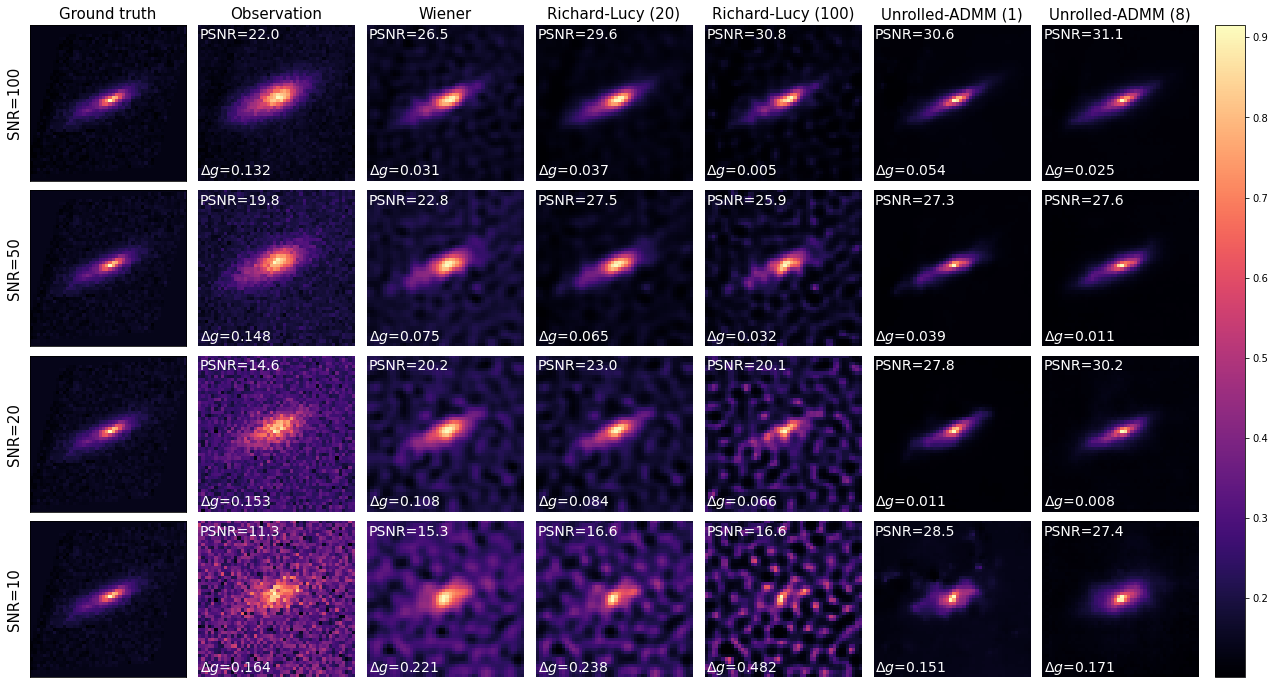

In [22]:
fig = plt.figure(figsize=(21,12), facecolor='white')
ax = plt.gca()
cmap = 'magma'
for idx, (gt, obs, snr, rec_fd, rec_RL_20, rec_RL_100, rec_1, rec_8) in enumerate(zip(gt_list, obs_list, snr_list, rec_wiener, rec_RL[0], rec_RL[1], rec_admm[0], rec_admm[1])):
    ax1 = plt.subplot(4,7,7*idx+1)
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(gt, cmap=cmap)
    # plt.title("SNR={:.1f}".format(snr),x=0.01,y=0.87,loc='left', fontsize=14, color='white')
    plt.ylabel("SNR={:.0f}".format(snr), fontsize=15)
    # plt.axis('off')
    ax1.set_xticks([])
    ax1.set_yticks([])
    if idx == 0:
        plt.title('Ground truth', fontsize=15)

    plt.subplot(4,7,7*idx+2)
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(obs, cmap=cmap)
    plt.title("PSNR={:.1f}".format(PSNR(obs,gt)),x=0.525,y=0.87,loc='right', fontsize=14, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(estimate_shear(obs.numpy(),psf_delta)[2]-estimate_shear(gt.numpy(),psf_delta)[2])),x=0.01,y=0,loc='left', fontsize=14, color='white')
    plt.axis('off')
    if idx == 0:
        plt.title('Observation', fontsize=15)

    plt.subplot(4,7,7*idx+3)
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(rec_fd, cmap=cmap)
    plt.title("PSNR={:.1f}".format(PSNR(rec_fd,gt)),x=0.525,y=0.87,loc='right', fontsize=14, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(estimate_shear(rec_fd.numpy(),psf_delta)[2]-estimate_shear(gt.numpy(),psf_delta)[2])),x=0.01,y=0,loc='left', fontsize=14, color='white')
    plt.axis('off')
    if idx == 0:
        plt.title('Wiener', fontsize=15)

    plt.subplot(4,7,7*idx+4)
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(rec_RL_20, cmap=cmap)
    plt.title("PSNR={:.1f}".format(PSNR(rec_RL_20,gt)),x=0.525,y=0.87,loc='right', fontsize=14, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(estimate_shear(rec_RL_20,psf_delta)[2]-estimate_shear(gt.numpy(),psf_delta)[2])),x=0.01,y=0,loc='left', fontsize=14, color='white')
    plt.axis('off')
    if idx == 0:
        plt.title('Richard-Lucy (20)', fontsize=15)

    plt.subplot(4,7,7*idx+5)
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(rec_RL_100, cmap=cmap)
    plt.title("PSNR={:.1f}".format(PSNR(rec_RL_100,gt)),x=0.525,y=0.87,loc='right', fontsize=14, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(estimate_shear(rec_RL_100,psf_delta)[2]-estimate_shear(gt.numpy(),psf_delta)[2])),x=0.01,y=0,loc='left', fontsize=14, color='white')
    plt.axis('off')
    if idx == 0:
        plt.title('Richard-Lucy (100)', fontsize=15)

    plt.subplot(4,7,7*idx+6)
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(rec_1, cmap=cmap)
    plt.title("PSNR={:.1f}".format(PSNR(rec_1,gt)),x=0.525,y=0.87,loc='right', fontsize=14, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(estimate_shear(rec_1,psf_delta)[2]-estimate_shear(gt.numpy(),psf_delta)[2])),x=0.01,y=0,loc='left', fontsize=14, color='white')
    plt.axis('off')
    if idx == 0:
        plt.title('Unrolled-ADMM (1)', fontsize=15)

    plt.subplot(4,7,7*idx+7)
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    plt.imshow(rec_8, cmap=cmap)
    plt.title("PSNR={:.1f}".format(PSNR(rec_8,gt)),x=0.525,y=0.87,loc='right', fontsize=14, color='white')
    plt.title("$\Delta g$={:.3f}".format(abs(estimate_shear(rec_8,psf_delta)[2]-estimate_shear(gt.numpy(),psf_delta)[2])),x=0.01,y=0,loc='left', fontsize=14, color='white')
    plt.axis('off')
    if idx == 0:
        plt.title('Unrolled-ADMM (8)', fontsize=15)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(cax=cax) # Similar to fig.colorbar(im, cax = cax)
plt.savefig('figures/grid.eps', bbox_inches='tight')